# Real Disposable Income and Savings in the Eurozone
Given that personal consumption expenditures make up a significant part of Euro area GDP, it is interesting to analyze dynamics in the disposable personal income of Euro area residents and their savings rate. 

Throughout this notebook I use real measures and ratios.

### Terminology
* **Personal income**: All income of an individual from labor, rentals (including imputed rentals from owner-occupied housing), investments, etc, as well as government social benefits net of employer contributions for government social insurance
* **Disposable personal income**: `Personal income` - `Taxes`
* **Personal savings**: `Disposable personal income` - `Personal consumption expenditures` - `Interest payments` - `Current transfer payments`. Interest payments are mostly mortgage payments and payments on credit cards. Current transfer payments include transfers to and from the government.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail

# Install the latest version of eurostat
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin, BDay, QuarterBegin

import eurostat

from datetime import date

In [3]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

In [4]:
MEAN_LEVEL_OF = 'Mean level of '
TAX_TO_INCOME = 'Taxes to Income'
REAL_DISPOSABLE_INCOME = 'Real Disposable Personal Income per Capita'
PSR = 'Personal Saving Rate'
INTEREST_PAYMENTS_TO_DPI = 'Interest payments to Disposable personal income'
PCE_TO_DPI = 'Personal consumption to Disposable personal income'
REAL_DISPOSABLE_INCOME_GROWTH_GRAPH_TITLE = REAL_DISPOSABLE_INCOME + ', Annual Growth Rate'
SAVINGS_RATE_GRAPH_TITLE = 'Personal saving as a percentage of disposable personal income'
MEAN_LEVEL_OF_SAVINGS_RATE = MEAN_LEVEL_OF + 'Savings rate'
MEAN_LEVEL_OF_INTEREST_PAYMENTS_TO_DPI = MEAN_LEVEL_OF + INTEREST_PAYMENTS_TO_DPI
MEAN_LEVEL_OF_REAL_DISPOSABLE_INCOME_GROWTH = MEAN_LEVEL_OF + REAL_DISPOSABLE_INCOME_GROWTH_GRAPH_TITLE

In [5]:
data = eurostat.get_data_df('nasq_10_ki', filter_pars={
    'startPeriod': report_start, 's_adj': 'SCA',
    'na_item': ['B7G_R_HAB_2010', 'SRG_S14_S15'], 'sector': 'S14_S15', 'geo': 'EA20'}).iloc[:, 6:]

data = data.set_index(data.columns[0]).T
data = data.set_axis(pd.DatetimeIndex(data.index, 'QS'))
data.dropna(inplace=True)
data.columns.names = [None]
data.columns = [REAL_DISPOSABLE_INCOME, PSR]

# Convert to decimal fractions
data.loc[:, PSR] /= 100.

In [6]:
data

,Real Disposable Personal Income per Capita,Personal Saving Rate
1999-01-01,88.81,0.1431
1999-04-01,89.33,0.141
1999-07-01,89.98,0.1371
1999-10-01,90.45,0.1314
2000-01-01,90.41,0.1278
...,...,...
2024-04-01,111.69,0.1539
2024-07-01,112.13,0.1518
2024-10-01,112.34,0.1498
2025-01-01,112.41,0.1518


### Real disposable income per capita
The question of whether the real disposable personal income per capita is growing or not is a vital economic indicator that signals changes in the standard of living. In the below graph I depict it using real terms per capita (2010=100).

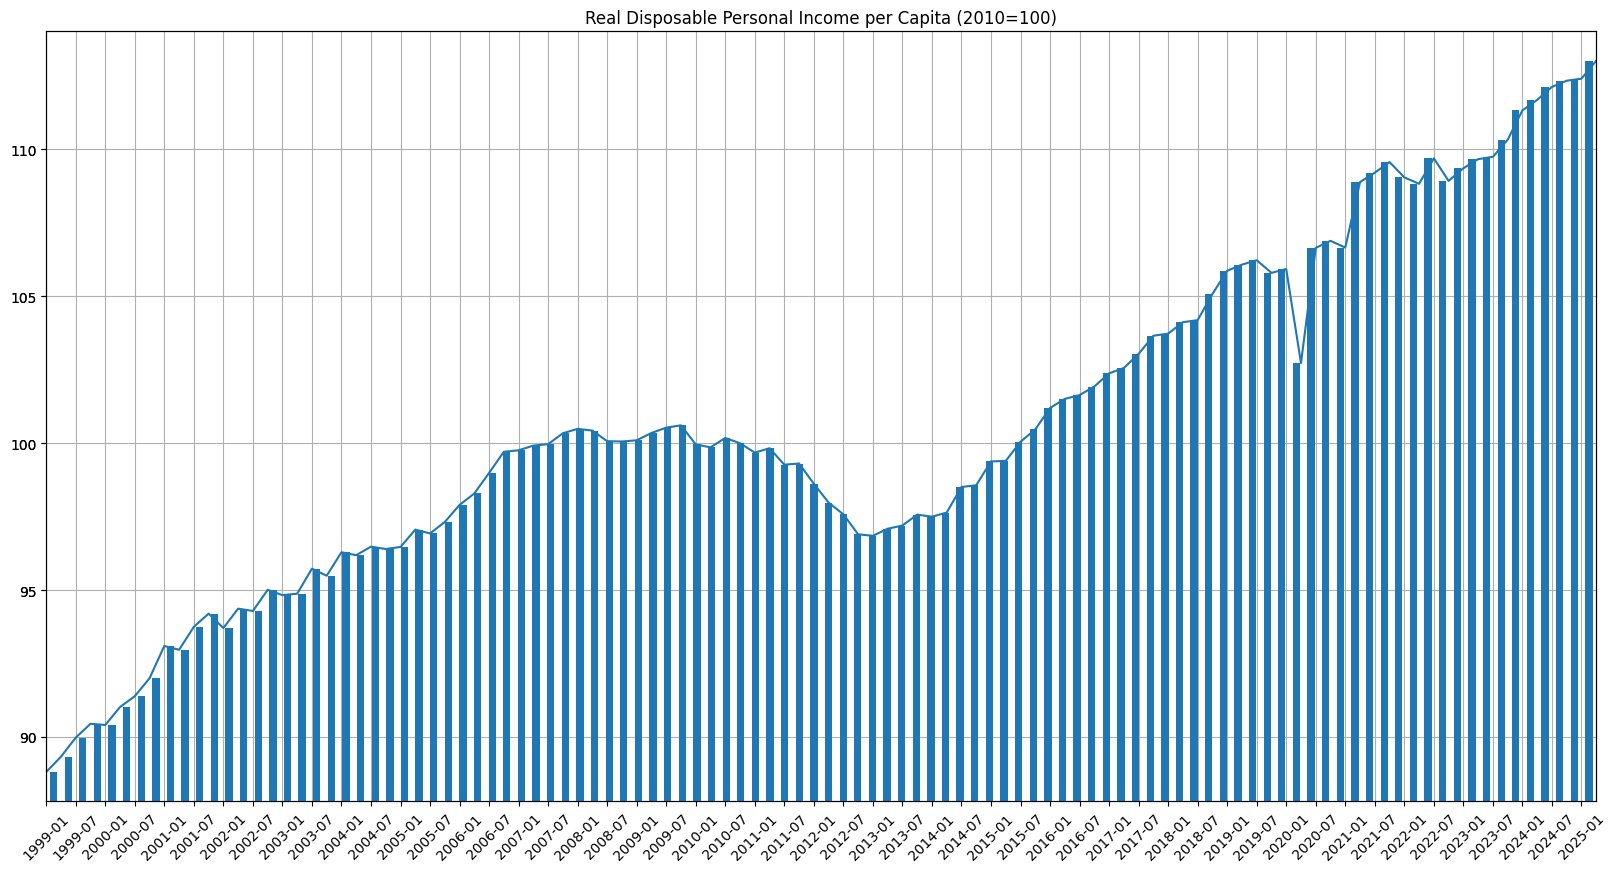

In [7]:
ax = data.loc[:,REAL_DISPOSABLE_INCOME].plot(figsize=(20,10), grid=True,
                                     title=REAL_DISPOSABLE_INCOME + ' (2010=100)',
                                     xticks=data.index[::2], xlabel='', rot=45)
ax2 = ax.twiny()
min_dpi, max_dpi = data.loc[:,REAL_DISPOSABLE_INCOME].min() - 1, data.loc[:,REAL_DISPOSABLE_INCOME].max() + 1
data.loc[:,REAL_DISPOSABLE_INCOME].plot.bar(ax=ax2, xlabel='', legend=False, ylim=(min_dpi, max_dpi))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data.index[::2])))

#### Annual growth rate of real disposable income per capita
Let's look at the annual growth rate of real disposable income per capita.

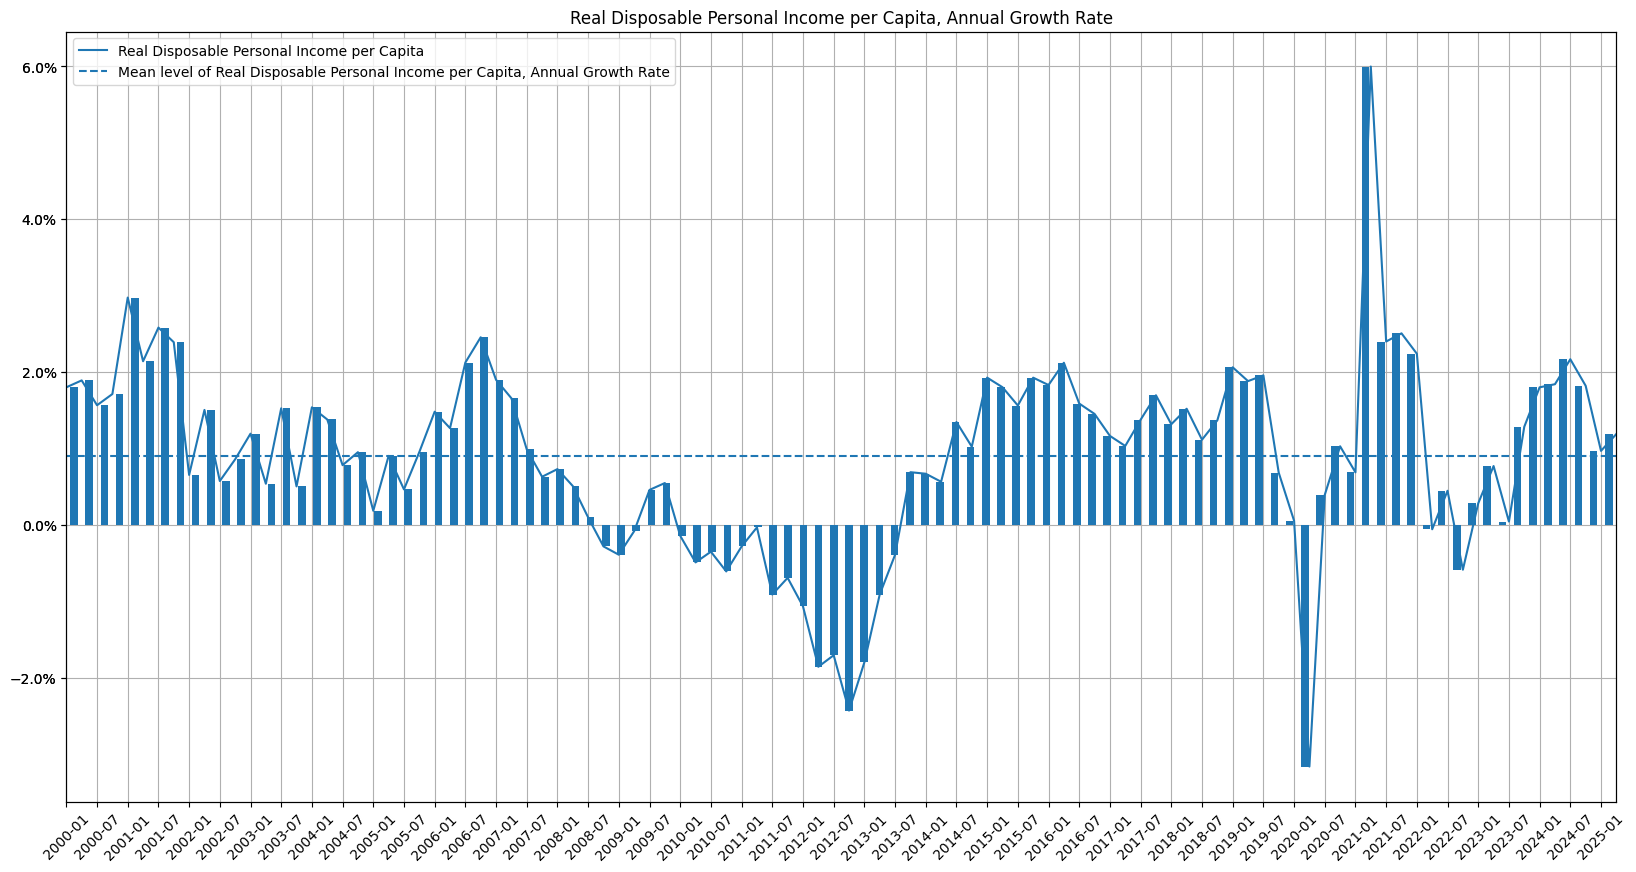

In [8]:
# Quarterly frequency
pi_growth = data.loc[:,REAL_DISPOSABLE_INCOME].pct_change(4, fill_method=None).dropna()
ax = pi_growth.plot(figsize=(20,10), grid=True,
                    title=REAL_DISPOSABLE_INCOME_GROWTH_GRAPH_TITLE,
                    xticks=pi_growth.index[::2], xlabel='', rot=45)
ax2 = ax.twiny()
pi_growth.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=pi_growth.mean(), ls='--', c='#1f77b4', label=MEAN_LEVEL_OF_REAL_DISPOSABLE_INCOME_GROWTH)
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pi_growth.index[::2])))

In [9]:
print(f'Mean level of real disposable income per capita growth rate since {pi_growth.index[0]:%Y-%m-%d}: {pi_growth.mean():.2%}')
print(f'The current level is {pi_growth.iloc[-1] - pi_growth.mean():+.2%} vs the mean')

Mean level of real disposable income per capita growth rate since 2000-01-01: 0.90%
The current level is +0.29% vs the mean


The mean level of annual growth of real disposable income per capita is actually lower than [the average annual growth of Euro area real GDP](./HICP_and_ECB_Rates.ipynb), which is 1.63%.

### Savings rate
Personal saving as a percentage of disposable personal income (DPI), frequently referred to as "the personal saving rate" is calculated as the ratio of personal saving to DPI. Personal saving is equal to personal income less personal outlays and personal taxes; it may generally be viewed as the portion of personal income that is used either to provide funds to capital markets or to invest in real assets such as residences.

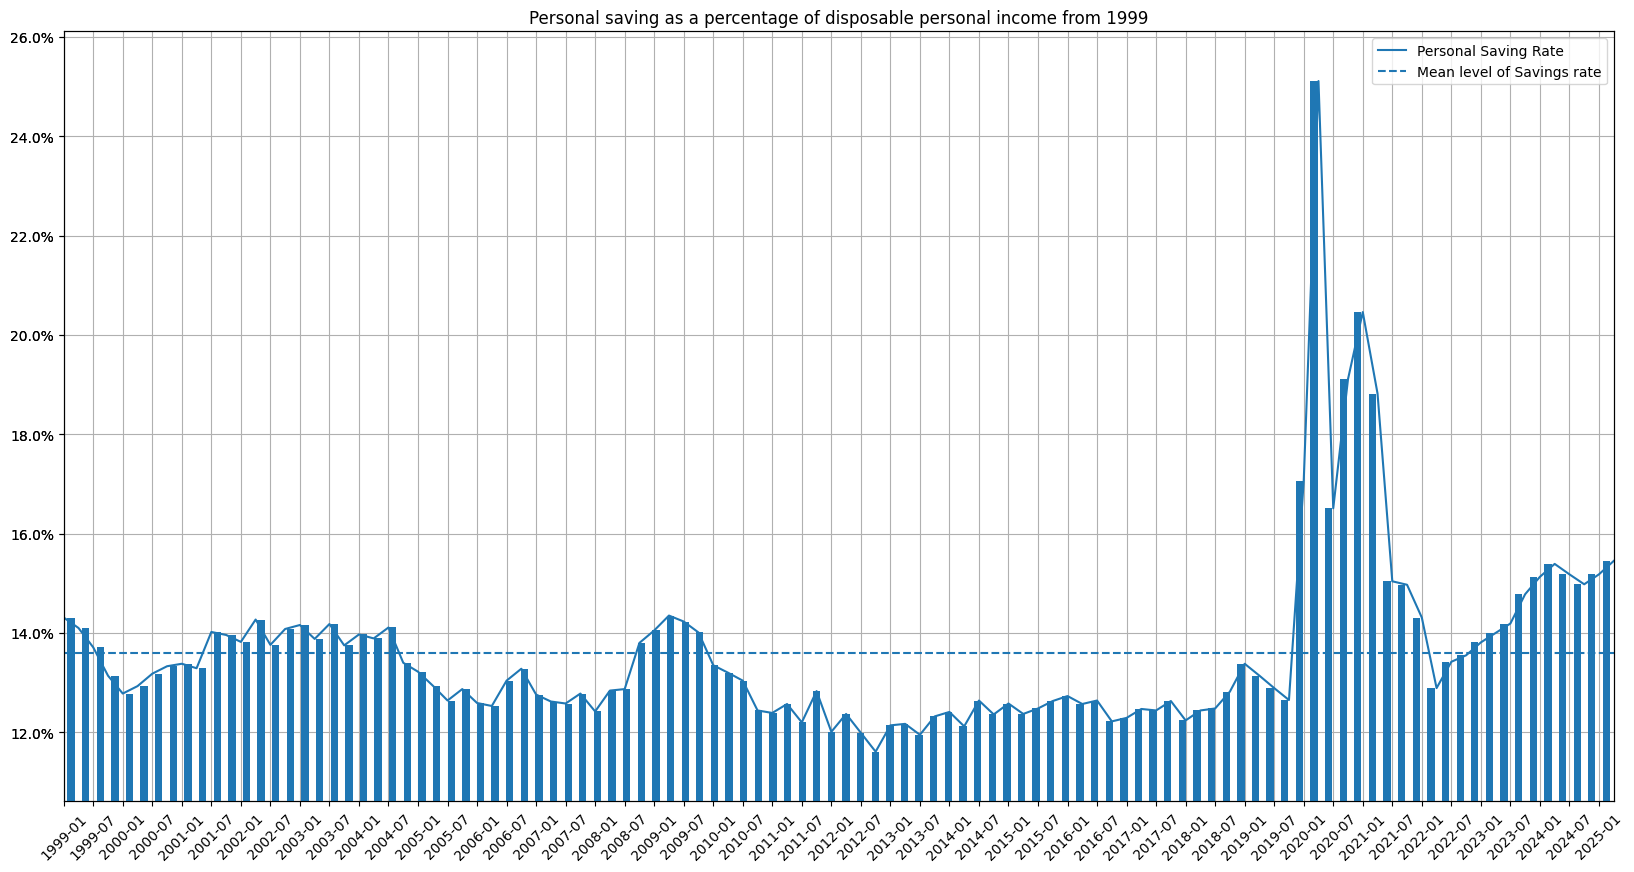

In [10]:
ax = data.loc[:,PSR].plot(figsize=(20,10), grid=True,
                          title=SAVINGS_RATE_GRAPH_TITLE + ' from %d' % data.index[0].year,
                          xticks=data.index[::2], xlabel='', rot=45)
ax2 = ax.twiny()
min_sr, max_sr = data.loc[:,PSR].min() - .01, data.loc[:,PSR].max() + .01
data.loc[:,PSR].plot.bar(ax=ax2, xlabel='', legend=False, ylim=(min_sr, max_sr))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data.loc[:,PSR].mean(), ls='--', c='#1f77b4', label=MEAN_LEVEL_OF_SAVINGS_RATE)
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data.index[::2])))

In [11]:
print(f'Mean level of savings rate since {data.index[0]:%Y-%m-%d}: {data.loc[:,PSR].mean():.2%}')
print(f'The current level is {data.iloc[-1,1]-data.loc[:,PSR].mean():+.2%} vs the mean')

Mean level of savings rate since 1999-01-01: 13.60%
The current level is +1.85% vs the mean
